In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import Person

In [25]:
################################ CLASS VERSION #######################################
def RunEpidemic(nPop, n0, nDays, contacts_mean, contacts_std, prob_infection):
    #Initialize the population
    Population = [] #will be an array of persons
    InfectedIndices = [] #indices of those in Population that are infected

    #Add a bunch of persons to Population:
    for i in range(nPop):
        newperson = Person.Person(i)
        Population.append(newperson)
        
    #Infect the first n0 patients:      
    for i in range(n0):
        Population[i].infect(day=0)
        InfectedIndices.append(i)
        
    SusceptIndices = [i for i in range(len(Population)) if i not in InfectedIndices]
            
    #Arrays to store the values during the simulation                   
    new_infected = np.zeros(nDays, dtype=int) #new infections that day
    infected = np.zeros(nDays, dtype=int) #currently infected that day
    susceptible = np.zeros(nDays, dtype=int) #never been exposed that day
    recovered = np.zeros(nDays, dtype=int) #total recovered (immune) that day
    contagionRate = np.zeros(nDays, dtype=float)#the average number of people that one person has infected 
    
    #initially, nobody has recovered or infected anyone (just to initialize the arrays for day 0)
    nRecovered = 0
    nInfected_new = 0
    nRecovered_new = 0
    
    #Loop over the number of days
    for day in range(nDays):
        
        #Tally the counts from the previous day (so all these values are at the beginning of the day)
        nInfected = len(InfectedIndices)#number of infected people (end of yesterday or patients zero).
        infected[day] = nInfected
        
        new_infected[day] = nInfected_new#number of new infections (end of yesterday)
        
        if day >= 1: #nobody has recovered on day 0, otherwise, add those that recovered yesterday to the total
            nRecovered = recovered[day-1] + nRecovered_new
        recovered[day] = nRecovered
        nSusceptible = nPop - nInfected - nRecovered # already was healthy at the beginning of the day
        susceptible[day] = nSusceptible
        
        #Reset tallies for today:
        nRecovered_new = 0 #newly recovered today
        nInfected_new = 0 #newly infected today
        
        #Keep track of the number of people that each infected person infects (total, not just today). The average of those 
        #is then the current average number of people infected by infected people at that time (not quite R_0).
        nOthers_infected = np.zeros(nInfected,dtype=int)
        
        #Loop over the infected people:
        iinf = 0 #index to count over infected people
        #Need to sample over a copy of the indices, since Infected indices will change during the loop
        last_InfectedIndices = copy.deepcopy(InfectedIndices)
        for iper in last_InfectedIndices:           
            per = Population[iper] #Pull an infected person from the population
            
            #This person has, so far, infected this many people:
            nOthers_infected[iinf] = len(per.get_others_infected())
            iinf += 1
            
            #Randomly draw a number of contacts that this person will have
            ncontacts = abs(round(np.random.normal(contacts_mean,contacts_std)))
            #Factor in the probability that they will infect those contacts:
            ncontacts = round(ncontacts*prob_infection)
            new_infections = ncontacts
            
            if new_infections > 0:
                #Infect those people 
                actual_new_infections = per.infect_others(pop_list=Population,suscept_pop=SusceptIndices, 
                                                          day=day, num_to_infect=new_infections)
                # If there were suscept people to infect:
                if actual_new_infections>0:
                    # Add actual number of infected
                    nInfected += actual_new_infections
                    recent_infections = per.get_recent_infections()
                    # Add indices of those infected
                    InfectedIndices.extend(recent_infections)
                    
                    # Remove those infected from suscept 
                    for i in range(actual_new_infections):
                        SusceptIndices.remove(recent_infections[i])
                    
            #Check if this person has been sick for long enough to be cured (if yes, cure them!)
            is_cured = per.check_cured(day) # method will check and cure them 
            if is_cured:
                InfectedIndices.remove(per.get_index())
                nRecovered_new +=1
        
        
        if len(nOthers_infected) < 1:
            meanContagions = 0
        else:
            meanContagions = nOthers_infected.mean()
            
        contagionRate[day] = meanContagions
        
        print("Day: {}, infected: {}, recovered: {}, mean contagions per infected person: {}".format(day, nInfected, nRecovered, meanContagions))
    print("At the end, ",susceptible[-1],"never got it")
    print(np.max(infected),"had it at the peak")
    
    contagions = []
    for per in Population:
        contagions.append(len(per.get_others_infected()))
    print("The mean contagion rate is:",np.mean(contagions))
    
    return infected, new_infected, recovered, susceptible, Population

In [26]:
##Run a simulation
nDays = 90 #simulation length
nPop = int(1e4) #the population
n0 = 35 # number infected on day 0

#Transmissibility 
contacts_mean = 1 # mean number of people in contact per day
contacts_std = 1 #std number of contacts
prob_infection = 0.5 #probability of infecting a contact

infected, new_infected, recovered, susceptible, Population = RunEpidemic(nPop,n0, nDays,contacts_mean, contacts_std,
                                                                         prob_infection)


Day: 0, infected: 49, recovered: 0, mean contagions per infected person: 0.0
Day: 1, infected: 70, recovered: 0, mean contagions per infected person: 0.2857142857142857
Day: 2, infected: 95, recovered: 0, mean contagions per infected person: 0.5
Day: 3, infected: 135, recovered: 0, mean contagions per infected person: 0.631578947368421
Day: 4, infected: 181, recovered: 0, mean contagions per infected person: 0.7407407407407407
Day: 5, infected: 244, recovered: 0, mean contagions per infected person: 0.8066298342541437
Day: 6, infected: 326, recovered: 0, mean contagions per infected person: 0.8565573770491803
Day: 7, infected: 455, recovered: 0, mean contagions per infected person: 0.8926380368098159
Day: 8, infected: 627, recovered: 0, mean contagions per infected person: 0.9230769230769231
Day: 9, infected: 855, recovered: 0, mean contagions per infected person: 0.9441786283891547
Day: 10, infected: 1147, recovered: 0, mean contagions per infected person: 0.9590643274853801
Day: 11, 

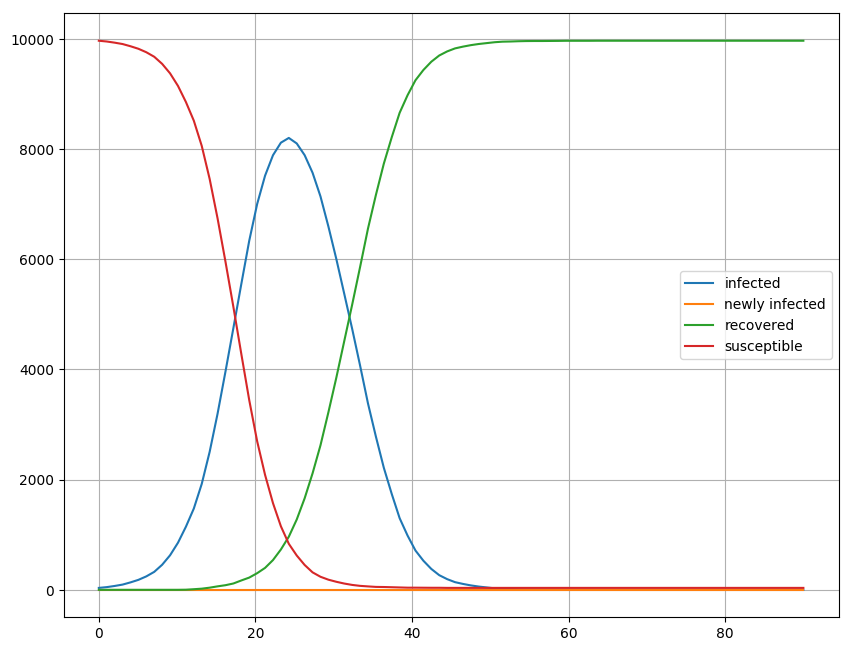

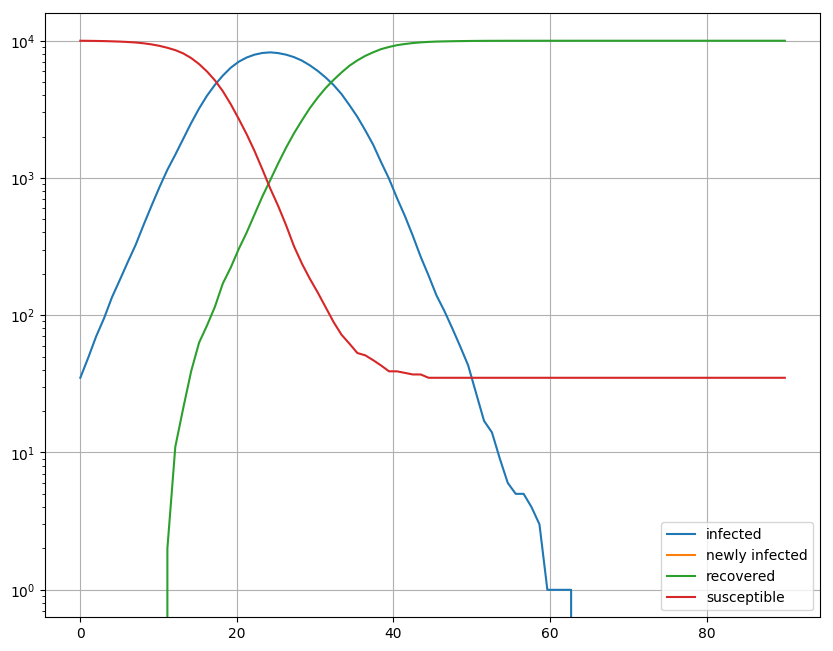

In [28]:
days = np.linspace(0,len(infected),len(infected))

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(days,infected,label="infected")
plt.plot(days,new_infected,label="newly infected")
plt.plot(days,recovered,label="recovered")
plt.plot(days,susceptible,label="susceptible")
plt.grid()
plt.legend()

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(days,infected,label="infected")
plt.plot(days,new_infected,label="newly infected")
plt.plot(days,recovered,label="recovered")
plt.plot(days,susceptible,label="susceptible")
plt.grid()
plt.legend()
plt.yscale("log")
plt.show()

#fig = pl.figure(figsize=(10,8))
#pl.hist(contagions,bins=np.linspace(0,15,16),edgecolor='black')
#pl.grid()
#pl.title("Mean contagions "+str(np.mean(contagions)))
#pl.show()
